In [2]:
import pickle
import sys

import ray
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import healpy as hp
import os

import GCE.gce
gce = GCE.gce.Analysis()
gce.load_params("../parameter_files/parameters.py")

2023-04-14 11:13:39.756315: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-14 11:13:39.756361: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


2023-04-14 11:13:57.520817: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-14 11:13:57.655738: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-04-14 11:13:58.022563: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-14 11:13:58.038067: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 computeCapability: 7.5
coreClock: 1.515GHz coreCount: 14 deviceMemorySize: 4.00GiB deviceMemoryBandwidth: 178.84GiB/s
202

Number of devices: 1
Loading parameters from '../parameter_files/parameters.py'...
Loading parameters: ['Edep' 'comb' 'data' 'gen' 'mod' 'nn' 'plot' 'train' 'tt']


In [3]:
ray_settings = {"num_cpus": 4}  # select the number of CPUs here
#gce.generate_template_maps(ray_settings, n_example_plots=5, job_id=0)

#gce.combine_template_maps(save_filenames=True, do_combine=True)

In [4]:
gce.build_pipeline()

2023-04-14 11:14:37.986285: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-04-14 11:14:37.987012: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2496005000 Hz


Input pipeline successfully built.


In [5]:
row=len(gce.p.Edep.keys())-2
col=len(gce.p.data["Ebins"])-1
print(col)

10


In [6]:
samples = gce.datasets["train"].get_samples(200)
data, labels = samples["data"], samples["label"]

Training: End of epoch!
Training: End of epoch!
Training: End of epoch!


Training: End of epoch!
Training: End of epoch!
Training: End of epoch!
Training: End of epoch!
Training: End of epoch!
Training: End of epoch!
Training: End of epoch!


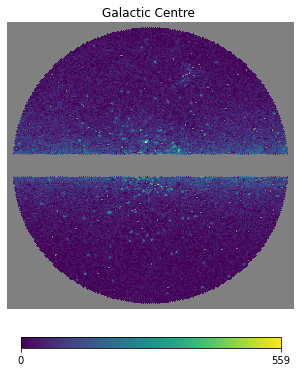

26.0


In [7]:
samples = gce.datasets["train"].get_samples(200)
data, labels = samples["data"], samples["label"]
# NOTE: the maps are stored in NEST format
map_to_plot = 0 #index of which map is plotted
r = gce.p.data["outer_rad"] + 1
#insert the params
fig, ax= plt.subplots(2,5,figsize = (40,20))

subplot=1
[axi.set_axis_off() for axi in ax.ravel()]
plt.tight_layout()
for Ebin in range(0,5):

    hp.cartview(gce.decompress(data[map_to_plot,:,Ebin] * gce.template_dict["rescale_compressed"][:,Ebin], fill_value=np.nan), nest=True,
                 lonra=[-r, r], latra=[-r, r], sub=(2,5,subplot), title='Counts Bin ' + str(Ebin))

    hp.cartview(gce.decompress(data[map_to_plot,:,Ebin], fill_value=np.nan), nest=True,
                 lonra=[-r, r], latra=[-r, r], sub=(2,5,5+subplot), title='Flux Bin ' + str(Ebin))
    subplot+=1

plt.show()

hp.cartview(gce.decompress(data[map_to_plot,:,:].sum(1) * gce.template_dict["rescale_compressed"][:,:].sum(1), fill_value=np.nan), nest=True,
                 lonra=[-r, r], latra=[-r, r],  title='Galactic Centre ')
plt.savefig("Galactic Centre")
plt.show()
print(r)

In [8]:
unique,counts=np.unique(gce.decompress(data[map_to_plot,:,0] * gce.template_dict["rescale_compressed"][:,0]),return_counts=True)
print(str(unique[0]) + " " + str(counts[0]))

unique,counts=np.unique(gce.decompress(data[map_to_plot,:,9] * gce.template_dict["rescale_compressed"][:,9]),return_counts=True)
print(str(unique[0]) + " " + str(counts[0]))


0.0 772946
0.0 772905


In [9]:
map_bin_0=gce.decompress(data[map_to_plot,:,0] * gce.template_dict["rescale_compressed"][:,0])
map_bin_0_mask=map_bin_0==0
map_bin_9=gce.decompress(data[map_to_plot,:,9] * gce.template_dict["rescale_compressed"][:,9])
map_bin_9_mask=map_bin_9==0

In [10]:
map_bin_0.shape

(786432,)

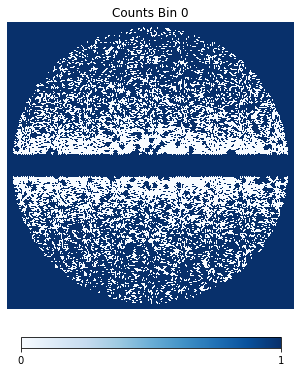

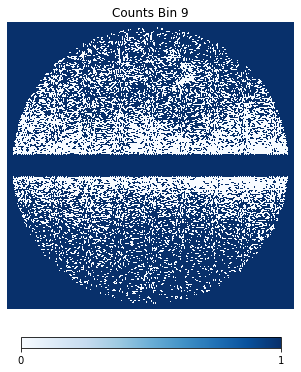

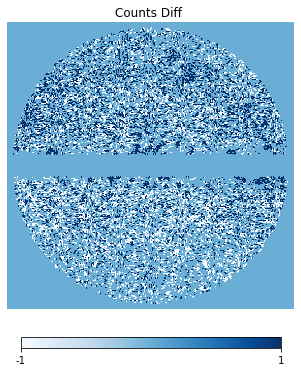

In [11]:
hp.cartview(map_bin_0_mask, nest=True,
                 lonra=[-r, r], latra=[-r, r], title='Counts Bin ' + str(0), cmap="Blues")
plt.show()
hp.cartview(map_bin_9_mask, nest=True,
                 lonra=[-r, r], latra=[-r, r], title='Counts Bin ' + str(9), cmap="Blues")
plt.show()
mask_diff=map_bin_0_mask.astype("int")-map_bin_9_mask.astype("int")

hp.cartview(mask_diff, nest=True,
                 lonra=[-r, r], latra=[-r, r], title='Counts Diff ', cmap="Blues")
plt.show()

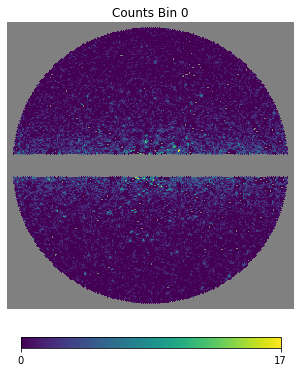

In [12]:
hp.cartview(gce.decompress(data[map_to_plot,:,0] * gce.template_dict["rescale_compressed"][:,0], fill_value=np.nan), nest=True,
                 lonra=[-r, r], latra=[-r, r], title='Counts Bin ' + str(0))
plt.show()
hp.cartview(gce.decompress(data[map_to_plot,:,9] * gce.template_dict["rescale_compressed"][:,9], fill_value=np.nan), nest=True,
                 lonra=[-r, r], latra=[-r, r], title='Counts Bin ' + str(9))
plt.show()

In [13]:
gce.template_dict["rescale_compressed"].shape

(32892, 10)

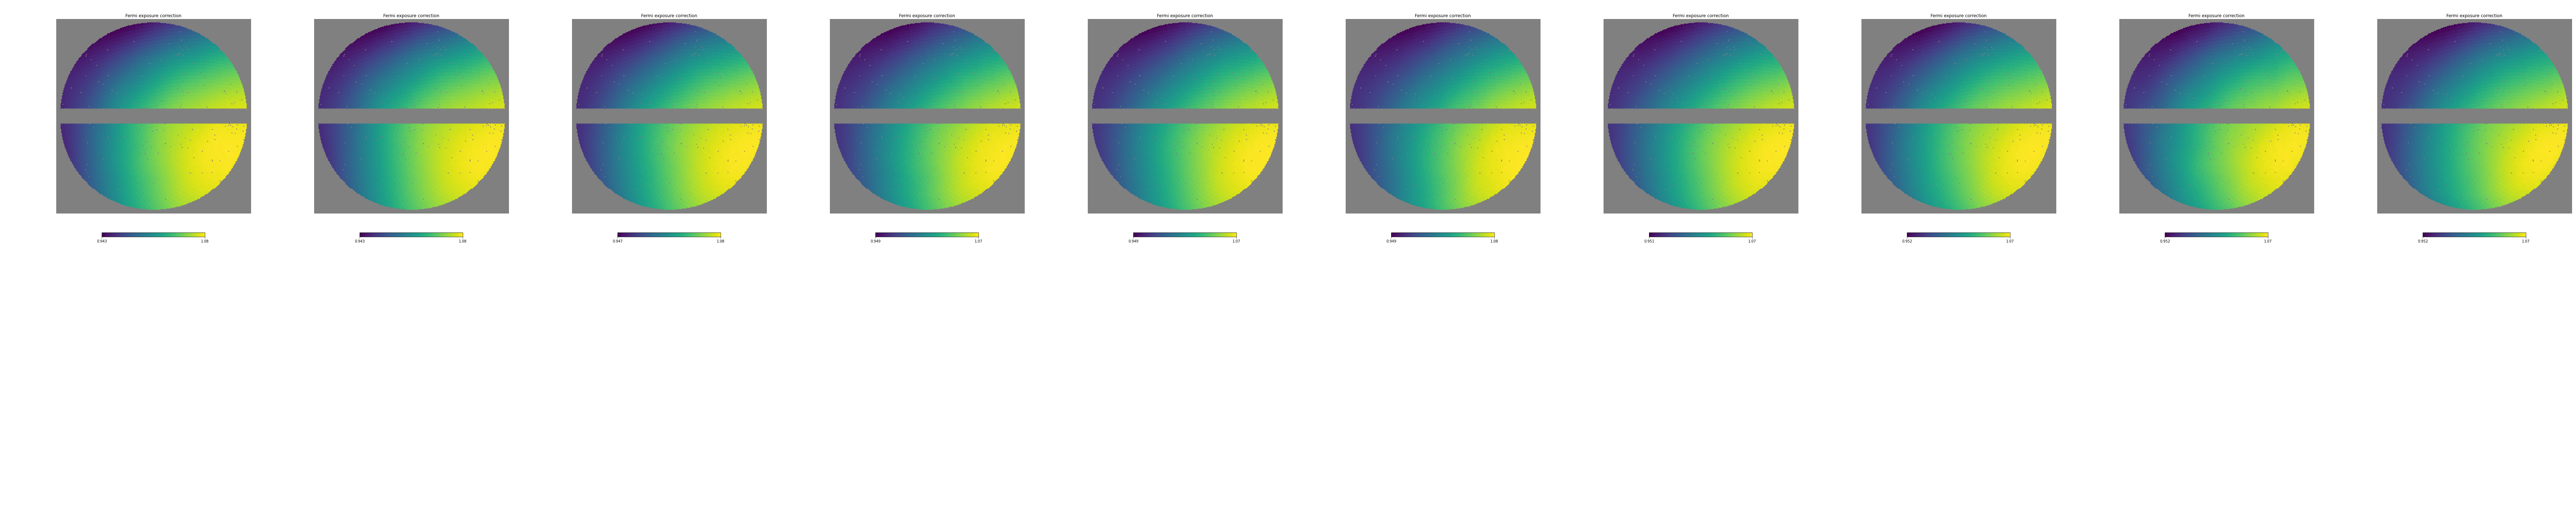

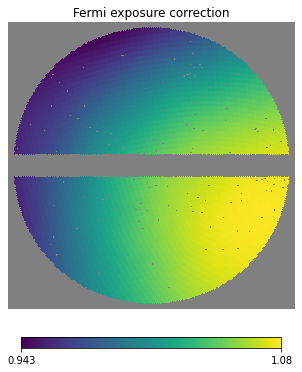

In [14]:
fig, ax= plt.subplots(2,col,figsize = (100,20))

subplot=1
[axi.set_axis_off() for axi in ax.ravel()]
plt.tight_layout()


for Ebin in range(0,len(gce.p.data["Ebins"])-1):
    hp.cartview(gce.decompress(gce.template_dict["rescale_compressed"][:,Ebin], fill_value=np.nan), nest=True,
                title="Fermi exposure correction", lonra=[-r, r], sub=(2,col,subplot), latra=[-r, r])
    subplot+=1

plt.show()

hp.cartview(gce.decompress(gce.template_dict["rescale_compressed"][:,0], fill_value=np.nan), nest=True,
                title="Fermi exposure correction", lonra=[-r, r], latra=[-r, r])
plt.show()

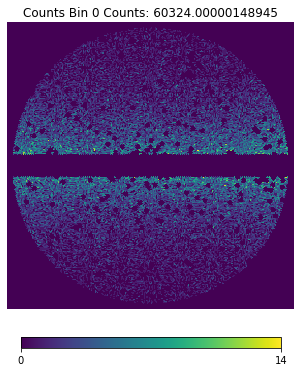

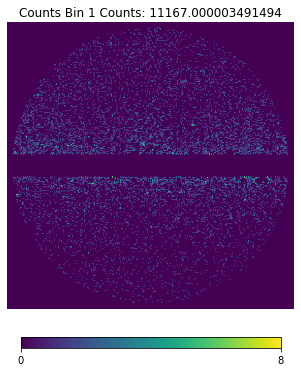

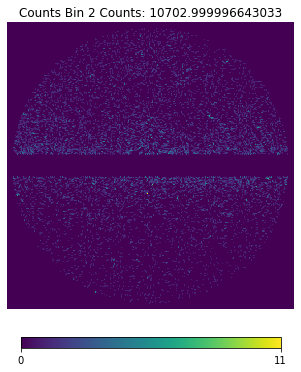

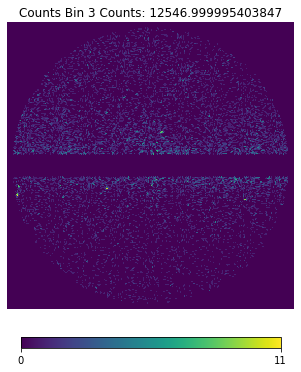

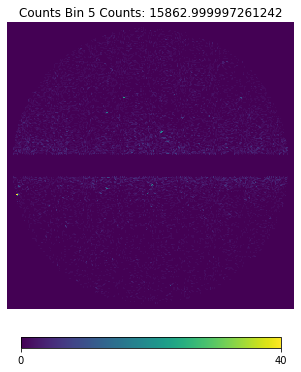

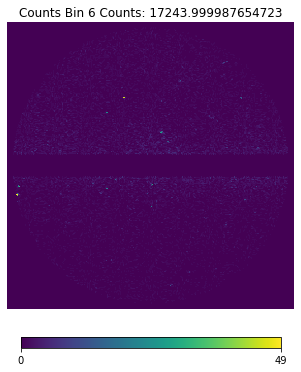

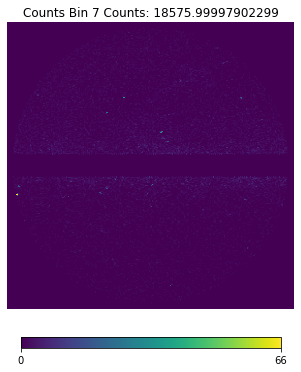

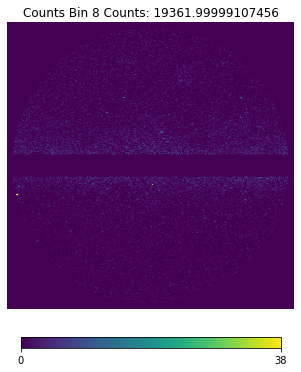

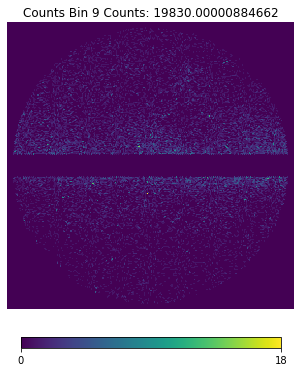

In [15]:
map_to_plot=1
gce.plot_mean_spectra(data[map_to_plot])
plt.show()


for Ebin in range(0,len(gce.p.data["Ebins"])-1):
    maps = gce.decompress(data[map_to_plot,:,Ebin] * gce.template_dict["rescale_compressed"][:,Ebin])
    hp.cartview(maps, nest=True,
                 lonra=[-r, r], latra=[-r, r], cmap= "viridis", title='Counts Bin ' + str(Ebin) + " Counts: " + str(maps.sum()))
    plt.show()

In [16]:
data_counts=data.sum(2).sum(1)
print(np.mean(data_counts))

192491.31


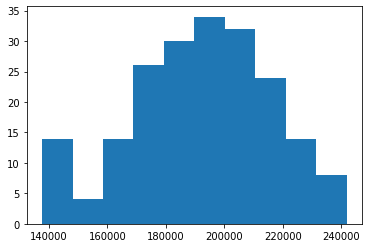

In [17]:
plt.hist(data_counts)
plt.show()

In [18]:
def get_template(fermi_folder, temp):
    """
    Returns a template.
    :param fermi_folder: folder containing the template maps
    :param temp: short name of template
    :return: template
    """
    if temp == "iso":
        t = np.load(os.path.join(fermi_folder, 'template_iso_smooth.npy'))
    elif temp == "dif":
        t = np.load(os.path.join(fermi_folder, 'template_dif.npy'))
    elif temp == "bub":
        t = np.load(os.path.join(fermi_folder, 'template_bub_smooth.npy'))
    elif temp == "bub_var":
        try:
            t = np.load(os.path.join(fermi_folder, 'template_nbub.npy'))
        except FileNotFoundError:
            t = np.load(os.path.join(fermi_folder, 'template_bub_alt.npy'))
    elif temp == "gce":
        try:
            t = np.load(os.path.join(fermi_folder, 'template_gce.npy'))
        except FileNotFoundError:
            t = np.load(os.path.join(fermi_folder, 'template_nfw_g1p0_smooth.npy'))
    elif temp == "gce_12":
        try:
            t = np.load(os.path.join(fermi_folder, 'template_gce_gamma_1.20.npy'))
        except FileNotFoundError:
            t = np.load(os.path.join(fermi_folder, 'template_nfw_g1p2_smooth.npy'))
    elif temp == "gce_12_N":
        t = np.load(os.path.join(fermi_folder, 'template_gce_gamma_1.20_N.npy'))
    elif temp == "gce_12_S":
        t = np.load(os.path.join(fermi_folder, 'template_gce_gamma_1.20_S.npy'))
    elif temp == "gce_12_PS":
        t = np.load(os.path.join(fermi_folder, 'template_nfw_g1p2.npy'))
    elif temp == "disk":
        t = np.load(os.path.join(fermi_folder, 'template_dsk.npy'))
    elif temp == "thin_disk":
        try:
            t = np.load(os.path.join(fermi_folder, 'template_disk_r_s_5_z_s_0.3.npy'))
        except FileNotFoundError:
            t = np.load(os.path.join(fermi_folder, 'template_dsk_z0p3.npy'))
    elif temp == "thin_disk_PS":
        try:
            t = np.load(os.path.join(fermi_folder, 'template_disk_r_s_5_z_s_0.3.npy'))
        except FileNotFoundError:
            t = np.load(os.path.join(fermi_folder, 'template_dsk_z0p3.npy'))
    elif temp == "thick_disk":
        try:
            t = np.load(os.path.join(fermi_folder, 'template_disk_r_s_5_z_s_1.npy'))
        except FileNotFoundError:
            t = np.load(os.path.join(fermi_folder, 'template_dsk_z1p0.npy'))

    elif temp == "dif_O_pibs":
        try:
            t = np.load(os.path.join(fermi_folder, 'ModelO_r25_q1_pibrem.npy'))
        except FileNotFoundError:
            t = np.load(os.path.join(fermi_folder, 'template_Opi.npy'))
    elif temp == "dif_O_ic":
        try:
            t = np.load(os.path.join(fermi_folder, 'ModelO_r25_q1_ics.npy'))
        except FileNotFoundError:
            t = np.load(os.path.join(fermi_folder, 'template_Oic.npy'))
    elif temp == "dif_A_pibs":
        t = np.load(os.path.join(fermi_folder, 'template_Api.npy'))
    elif temp == "dif_A_ic":
        t = np.load(os.path.join(fermi_folder, 'template_Aic.npy'))
    elif temp == "dif_F_pibs":
        t = np.load(os.path.join(fermi_folder, 'template_Fpi.npy'))
    elif temp == "dif_F_ic":
        t = np.load(os.path.join(fermi_folder, 'template_Fic.npy'))
    elif temp == "psc_3":
        try:
            t = np.load(os.path.join(fermi_folder, 'template_psc.npy'))
        except FileNotFoundError:
            t = np.load(os.path.join(fermi_folder, 'template_psc_3fgl.npy'))
    elif temp == "psc_4":
        t = np.load(os.path.join(fermi_folder, 'template_psc_4fgl.npy'))
    elif temp == "3FGL_mask":
        try:
            t = np.load(os.path.join(fermi_folder, 'fermidata_pscmask.npy'))
        except FileNotFoundError:
            t = np.load(os.path.join(fermi_folder, 'fermidata_pscmask_3fgl.npy'))
    elif temp == "4FGL_mask":
        t = np.load(os.path.join(fermi_folder, 'fermidata_pscmask_4fgl.npy'))
    elif temp == "exp":
        t = np.load(os.path.join(fermi_folder, 'fermidata_exposure.npy'))
    elif temp == "counts":
        t = np.load(os.path.join(fermi_folder, "fermidata_counts.npy"))
    elif temp == "fermi_map":
        t = np.load(os.path.join(fermi_folder, "fermidata_counts.npy"))
    else:
        raise NotImplementedError("Template", temp, "not available!")
    return t

In [19]:
fermi_data=get_template("/home/flo/GCE_NN/data/fermi_data_edep/fermi_data_256/", "fermi_map")
#TODO hist vom fermi data
#ffs in ebin

In [20]:
fermi_data.shape


(40, 786432)

In [21]:
mod_names=gce.p.mod["models_P"]+gce.p.mod["models_PS"]
print(mod_names)

['dif_O_pibs', 'dif_O_ic', 'iso', 'bub', 'gce_12_PS', 'thin_disk_PS']


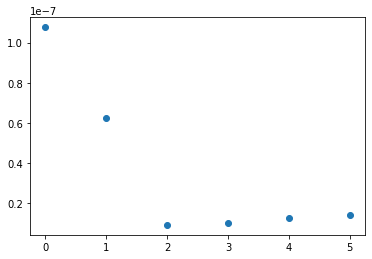

In [22]:
import pickle
data, labels = samples["data"], samples["label"]
dat=open("/home/flo/GCE_NN/data/Combined_maps/Example_comb_256/Train/Maps_00000_train.pickle", "rb")
key_data=pickle.load(dat)

mean_labels=[]
for temp in key_data["flux_fraction"].keys():
    mean_labels.append(key_data["flux_fraction"][temp].mean())

plt.scatter(range(0,6),mean_labels)
plt.show()

In [23]:
labels[0].std()


6.3041405e-08

In [24]:
mean_labels

[1.0760174413875552e-07,
 6.261812140587243e-08,
 9.289531020027108e-09,
 1.0095143587588815e-08,
 1.2967528329611985e-08,
 1.4080986139876466e-08]

In [25]:
key_data["flux_fraction"]["bub"]

array([[4.03121017e-10, 1.72905828e-09, 4.33362724e-09, 6.86885980e-09,
        8.42844932e-09, 8.56580403e-09, 8.03690557e-09, 7.37040928e-09,
        6.51371658e-09, 5.77378439e-09],
       [7.28882365e-10, 1.07333349e-09, 1.15537426e-09, 1.71189003e-09,
        2.19249133e-09, 3.09681075e-09, 3.47994873e-09, 4.33537941e-09,
        4.64498071e-09, 5.26825511e-09],
       [1.65410329e-08, 1.72198011e-08, 1.75504049e-08, 1.85659476e-08,
        1.92136341e-08, 1.85036272e-08, 1.79727774e-08, 1.91359320e-08,
        1.88816985e-08, 1.87263054e-08],
       [1.16703722e-10, 3.90361056e-10, 6.15356757e-10, 1.04554498e-09,
        1.72213755e-09, 2.40956825e-09, 3.66236561e-09, 3.71289253e-09,
        4.19376219e-09, 4.27938847e-09],
       [7.72025469e-09, 8.96018510e-09, 1.15062809e-08, 1.37406015e-08,
        1.58985774e-08, 1.83677077e-08, 1.93414478e-08, 2.18510127e-08,
        2.30740412e-08, 2.42202932e-08],
       [7.08993431e-09, 7.45098445e-09, 8.21401449e-09, 8.87473217e-09,
   

In [26]:
import pickle
bub=open("/home/flo/GCE_NN/data/Template_maps/Example_256/bub/Maps_0_0.pickle", "rb")
dif_O_ic=open("/home/flo/GCE_NN/data/Template_maps/Example_256/dif_O_ic/Maps_0_0.pickle", "rb")
dif_O_pibs=open("/home/flo/GCE_NN/data/Template_maps/Example_256/dif_O_pibs/Maps_0_0.pickle", "rb")
iso=open("/home/flo/GCE_NN/data/Template_maps/Example_256/iso/Maps_0_0.pickle", "rb")
thin_disk_PS=open("/home/flo/GCE_NN/data/Template_maps/Example_256/thin_disk_PS/Maps_0_0.pickle", "rb")
gce_12_PS=open("/home/flo/GCE_NN/data/Template_maps/Example_256/gce_12_PS/Maps_0_0.pickle", "rb")

bub=pickle.load(bub)
dif_O_ic=pickle.load(dif_O_ic)
dif_O_pibs=pickle.load(dif_O_pibs)
iso=pickle.load(iso)
thin_disk_PS=pickle.load(thin_disk_PS)
gce_12_PS=pickle.load(gce_12_PS)

[ 976 1049 1230 1332 1299 1378 1433 1524 1566 1550]


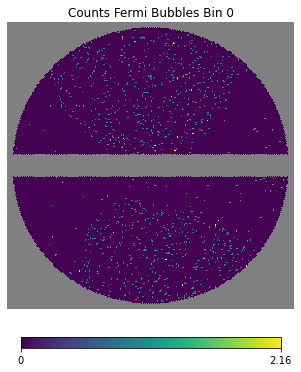

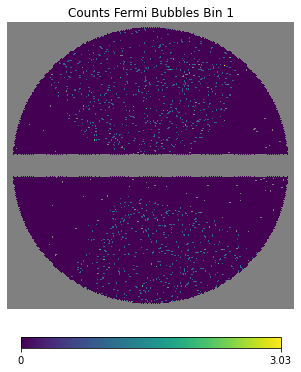

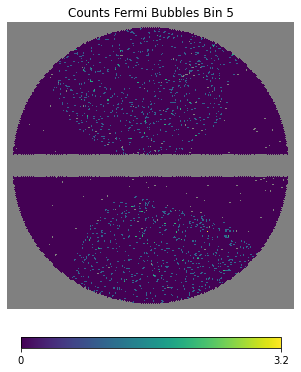

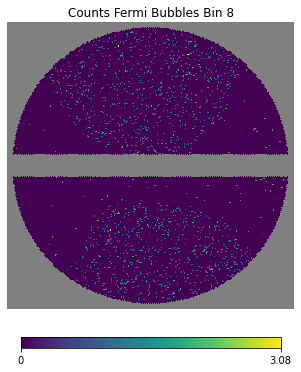

[35951 27677 20349 13740  8407  4584  2287  1099   447   146]


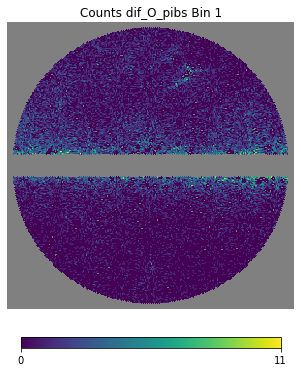

[7836 7944 8216 8133 8253 8180 7797 7729 7300 6781]


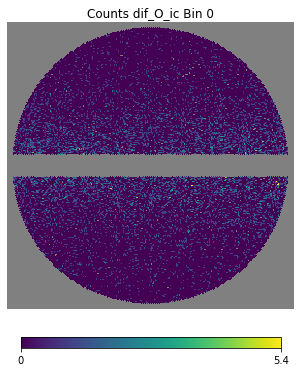

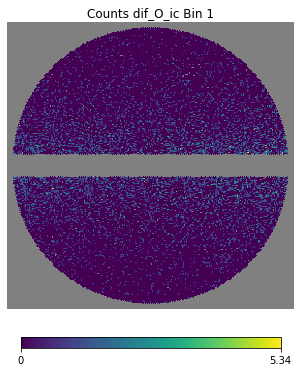

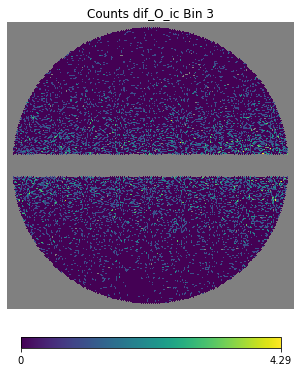

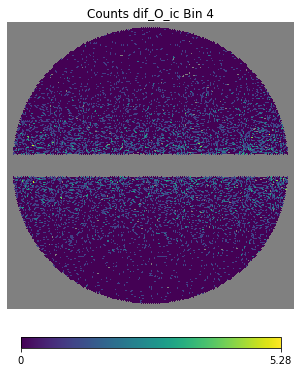

[222 239 262 260 265 251 277 291 304 282]


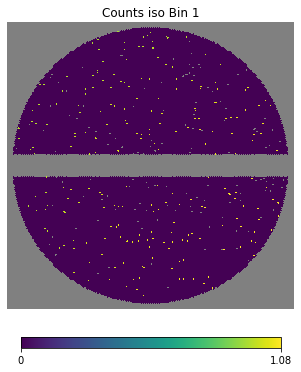

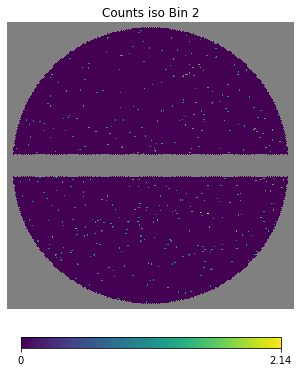

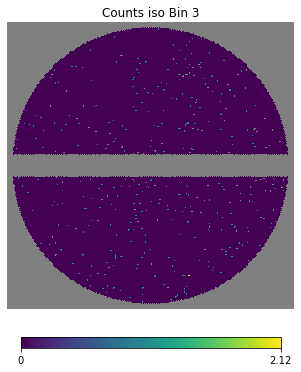

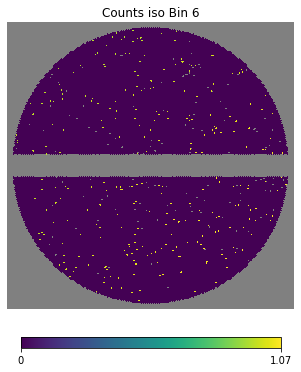

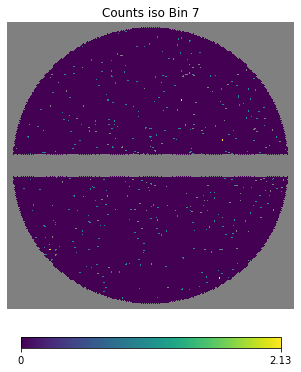

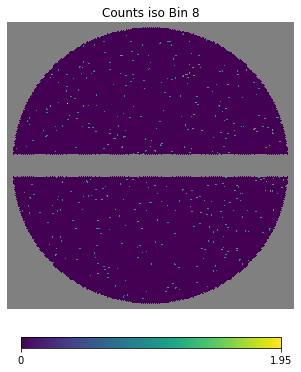

[ 756  887  996 1042 1151 1222 1180 1209 1321 1272]


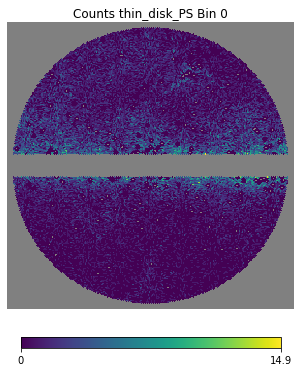

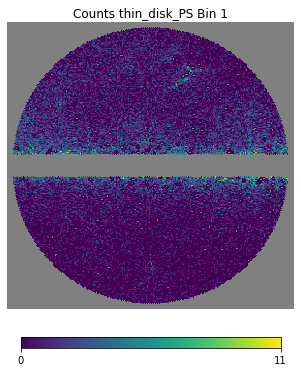

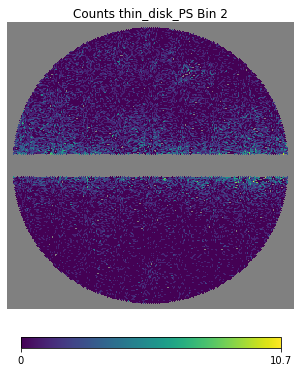

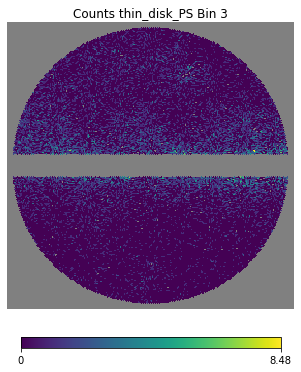

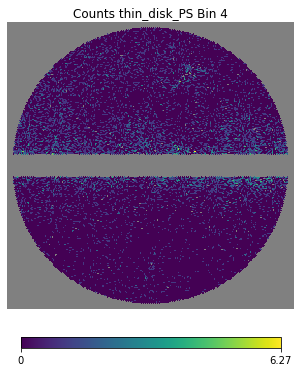

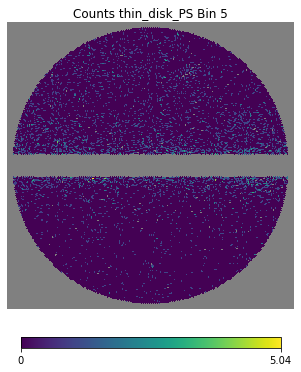

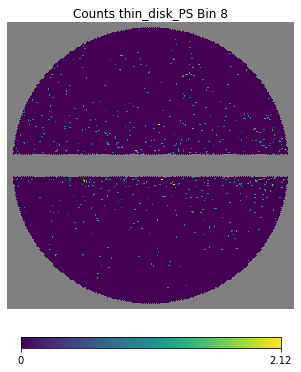

[1251 1367 1253 1271 1183 1301 1289 1231 1105 1161]


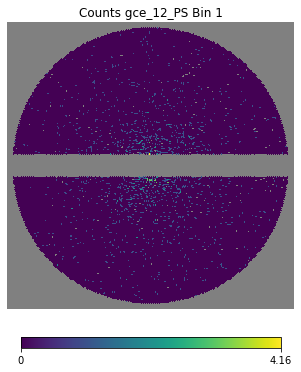

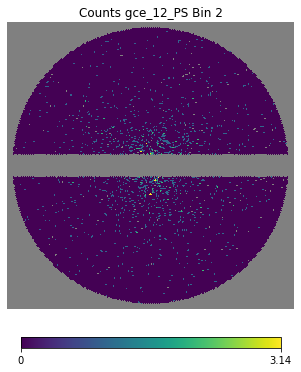

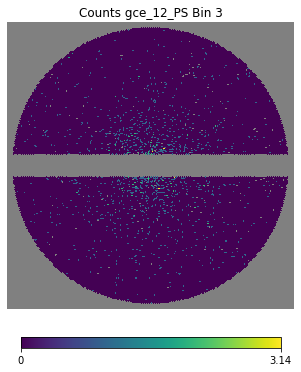

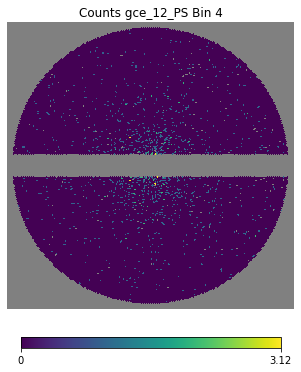

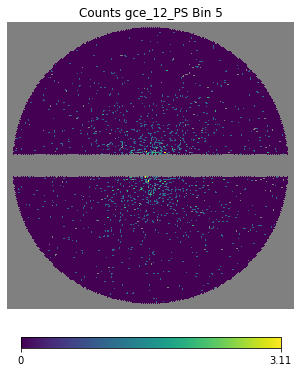

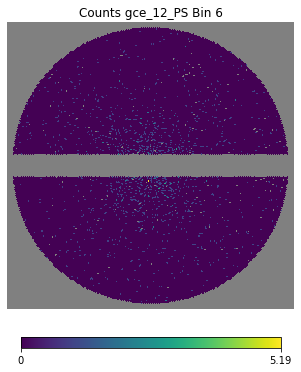

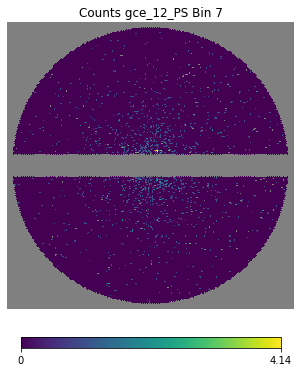

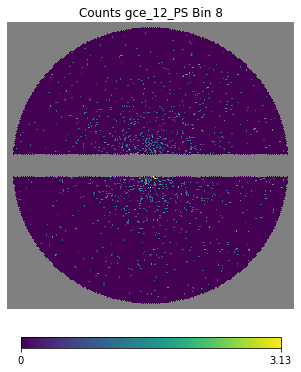

In [27]:
maps=0
bub["data"][0].shape
names=['dif_O_pibs', 'dif_O_ic', 'iso', 'bub', 'gce_12_PS', 'thin_disk_PS']
print(bub["data"][maps].sum(0))
for ebin in range(0,9):
    hp.cartview(gce.decompress(bub["data"][maps][:,ebin] * gce.template_dict["rescale_compressed"][:,ebin], fill_value=np.nan), nest=True, lonra=[-r, r], latra=[-r, r], title='Counts Fermi Bubbles Bin ' + str(ebin))
    plt.savefig('Counts Fermi Bubbles Bin ' + str(ebin))
    plt.show()

maps=20
print(dif_O_pibs["data"][maps].sum(0))
for ebin in range(0,9):
    hp.cartview(gce.decompress(dif_O_pibs["data"][maps][:,ebin] * gce.template_dict["rescale_compressed"][:,ebin], fill_value=np.nan), nest=True, lonra=[-r, r], latra=[-r, r], title='Counts dif_O_pibs Bin ' + str(ebin))
    plt.savefig('Counts dif_O_pibs Bin ' + str(ebin))
    plt.show()

maps=20
print(dif_O_ic["data"][maps].sum(0))
for ebin in range(0,9):
    hp.cartview(gce.decompress(dif_O_ic["data"][maps][:,ebin] * gce.template_dict["rescale_compressed"][:,ebin], fill_value=np.nan), nest=True, lonra=[-r, r], latra=[-r, r], title='Counts dif_O_ic Bin ' + str(ebin))
    plt.savefig('Counts dif_O_ic Bin ' + str(ebin))
    plt.show()

maps=20
print(iso["data"][maps].sum(0))
for ebin in range(0,9):
    hp.cartview(gce.decompress(iso["data"][maps][:,ebin] * gce.template_dict["rescale_compressed"][:,ebin], fill_value=np.nan), nest=True, lonra=[-r, r], latra=[-r, r], title='Counts iso Bin ' + str(ebin))
    plt.savefig('Counts iso Bin ' + str(ebin))
    plt.show()

maps=20
print(thin_disk_PS["data"][maps].sum(0))
for ebin in range(0,9):
    hp.cartview(gce.decompress(dif_O_pibs["data"][maps][:,ebin] * gce.template_dict["rescale_compressed"][:,ebin], fill_value=np.nan), nest=True, lonra=[-r, r], latra=[-r, r], title='Counts thin_disk_PS Bin ' + str(ebin))
    plt.savefig('Counts thin_disk_PS Bin ' + str(ebin))
    plt.show()

maps=2
print(gce_12_PS["data"][maps].sum(0))
for ebin in range(0,9):
    hp.cartview(gce.decompress(gce_12_PS["data"][maps][:,ebin] * gce.template_dict["rescale_compressed"][:,ebin], fill_value=np.nan), nest=True, lonra=[-r, r], latra=[-r, r], title='Counts gce_12_PS Bin ' + str(ebin))
    plt.savefig('Counts gce_12_PS Bin ' + str(ebin))
    plt.show()